In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [41]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [17]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", 
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

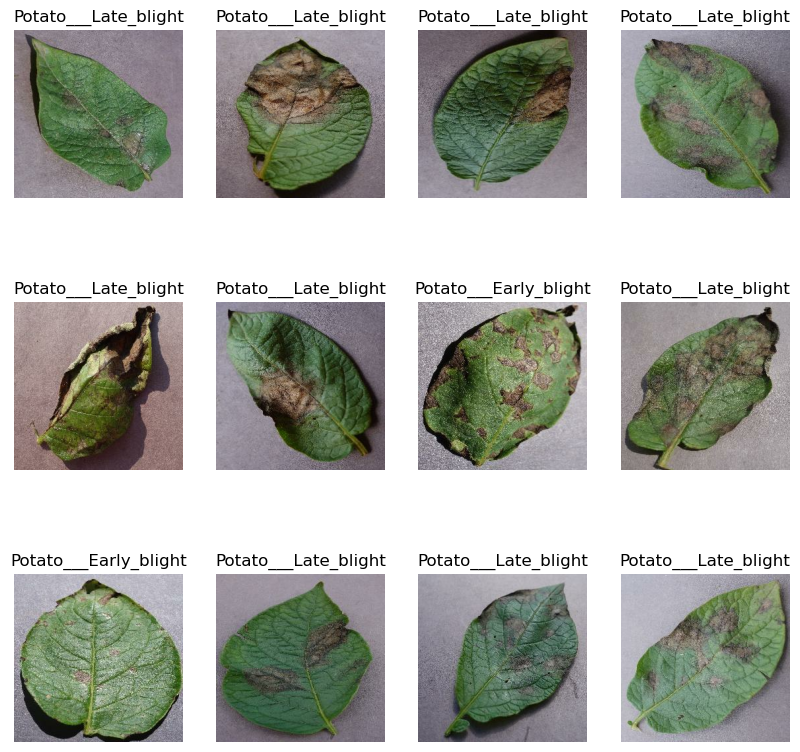

In [20]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [22]:
train_ds = dataset.take(54) # 80% of 68 or len of data set of batches
len(train_ds)

54

In [ ]:
val_ds = dataset.take(6) # batches after 54 for the 20% test
test_ds = test_ds.skip(6)

In [24]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    # function to partition and shuffle training and testing data
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds 

In [25]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [29]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # note--> check out videos on cache
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [31]:
# pre-processing watch tensorflow augemntation video
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE, IMAGE_SIZE),    
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [32]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [37]:
# Model neural network architecture

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    
    
])

model.build(input_shape=input_shape)

In [38]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256)                0         
                                                                 
 sequential_1 (Sequential)   multiple                  0         
                                                                 
 conv2d_7 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (32, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [74]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 32s 580ms/step - loss: 0.0393 - accuracy: 0.9873 - val_loss: 0.1698 - val_accuracy: 0.9427
Epoch 2/50
54/54 [==============================] - 32s 572ms/step - loss: 0.0502 - accuracy: 0.9818 - val_loss: 0.0516 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 32s 586ms/step - loss: 0.0180 - accuracy: 0.9947 - val_loss: 0.0281 - val_accuracy: 0.9896
Epoch 4/50
54/54 [==============================] - 31s 565ms/step - loss: 0.0121 - accuracy: 0.9953 - val_loss: 0.1186 - val_accuracy: 0.9688
Epoch 5/50
54/54 [==============================] - 31s 560ms/step - loss: 0.0399 - accuracy: 0.9877 - val_loss: 0.0477 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 31s 563ms/step - loss: 0.0541 - accuracy: 0.9789 - val_loss: 0.0184 - val_accuracy: 0.9896
Epoch 7/50
54/54 [==============================] - 32s 572ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0484 - val_accuracy: 0.9940

In [87]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 2s 158ms/step - loss: 0.0632 - accuracy: 0.9805


In [88]:
scores

[0.0632171630859375, 0.98046875]

In [84]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

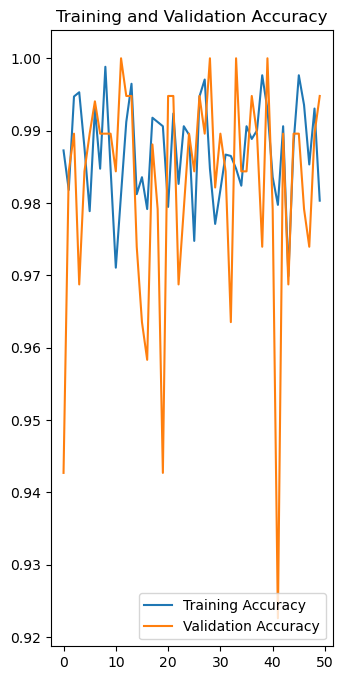

In [86]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



first image to predict
Actual cutal label: Potato___Early_blight
1/1 [==============================] - 0s 180ms/step
Potato___Early_blight


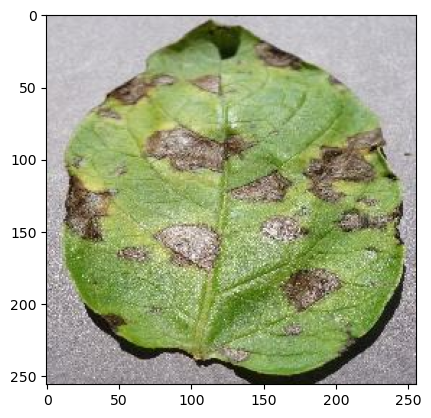

In [61]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("first image to predict")
    plt.imshow(first_image)
    print("Actual cutal label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(class_names[np.argmax(batch_prediction[0])])

In [92]:
# function to take in image and spit out predicted label

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    
    return predicted_class, confidence

1/1 [==============================] - 0s 25ms/step


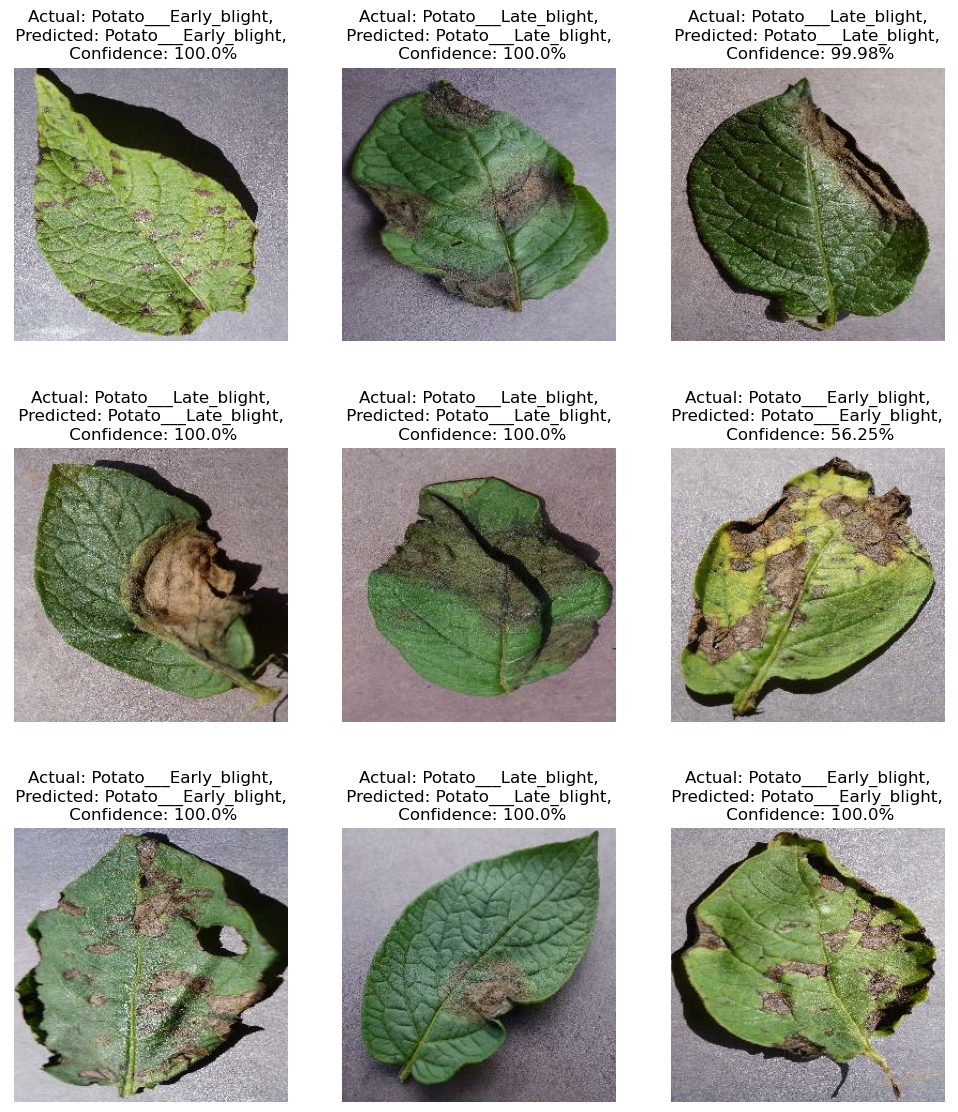

In [95]:
plt.figure(figsize=(12,14))
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")

In [98]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")
# cd /Users/lskarada/desktop/apcsprojects/Potato-App/api

INFO:tensorflow:Assets written to: ../saved_models/2/assets


INFO:tensorflow:Assets written to: ../saved_models/2/assets
